# Import the Libraries

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy import integrate
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from scipy.optimize import differential_evolution
from scipy.optimize import minimize, NonlinearConstraint
import json
from scipy.stats import norm
from scipy.integrate import solve_ivp
from scipy import integrate
import warnings
import time

In [3]:

import numpy as np
import scipy
import sklearn
import sys
import json
import warnings
import time

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("scikit-learn version:", sklearn.__version__)
print("JSON module: built-in")
print("Warnings module: built-in")
print("Time module: built-in")



Python version: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:23:22) [MSC v.1944 64 bit (AMD64)]
NumPy version: 2.2.6
SciPy version: 1.15.2
scikit-learn version: 1.7.2
JSON module: built-in
Warnings module: built-in
Time module: built-in


# Call the Custom Functions:
 - SMB function
 - Optimization function

The funcitons are written in separatep python scripts and need to be called from these locations. Lucky for us, we can us the "from" function in python to call an external script then specify which models (functions) we
want to "import" from the external script for our use. 

The optimization function is called "constrained_MOBO_func" and is sorted in the SMB_OPT script, while the SMB funciton is called "SMB" in the SMB_func_general script

In [30]:
from SMB_OPT import constrained_MOBO_func 
from SMB_func_general import SMB
from ploting_json_optimization_results import plot_raff_ext_pareto




### 📌 Assigning Variables to the SMB Functions
Before executing the SMB simulation or optimization routines, all input variables must be clearly defined. In Simulated Moving Bed (SMB) chromatography, inputs fall into three primary categories:

1. **System (Physical) Specifications** – e.g., column diameter and configuration  
2. **Thermodynamic Variables** – equilibrium and adsorption characteristics e.g., Henry's constant  
3. **Operating Variables** – e.g., flow rates and indexing parameters

Defining these correctly ensures the model accurately represents the physical system and can be used reliably for simulation and optimization.

---

### 1. System Specifications

Key decisions in this category include:

- **i. Number of columns per zone**: Define the number of columns in each zone (Z1, Z2, Z3, Z4).
- **ii. Column characteristics**: Since all columns are assumed to be identical, these specifications apply to all columns across the system.
- **iii. Column arrangement**: Determine the configuration of input and output nodes for each column, including any subzoning considerations.



**i. Number of columns per zone**

Specify how many columns belong to each of the four SMB zones (e.g., ZI, ZII, ZIII, ZIV).

In [10]:
Z1, Z2, Z3, Z4 = 1,1,1,1 # *3 for smb config
zone_config = np.array([Z1, Z2, Z3, Z4])

 **ii. Column Characteristics**

In [11]:
L = 71 # Length of one column
d_col = 5 # Column internal diameter
e = 0.56   # bed voidage

# Calculate the:
# Radius,
r_col = d_col / 2
# Area,
A_col = np.pi * (r_col ** 2) # cm^2
# Volume,
V_col = A_col*L # cm^3
# ---------------------------------------------------------
# Assuming the pipe diameter is 20% of the column diameter:
d_in = 1 # cm

**iii. Column Arrangement**

Typically, each column feeds its proceeding column in the column train, this can be depicted below for the 1:1:1:1 configuration. In the SMB model, the feed is always placed in-btween zones 2 and 3. 

In the configuration below, vertical dotted lines represent the demarckations between zones also showing where the Feed, Raffinate, Extract or Desorbent ports are located. The "Bays" act as position 

labels of the system. For instance, the columns are initally located at the Bays with the same number-labels i.e. column 1 at Bay 1,  col 2 at Bay 2 and so on. 


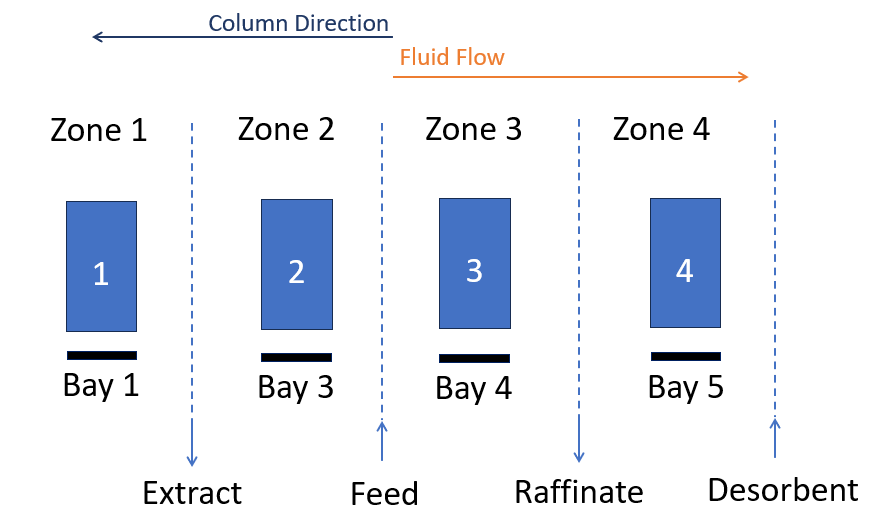



After the first indexing period, the columns shift to the left resulting in the figure below.

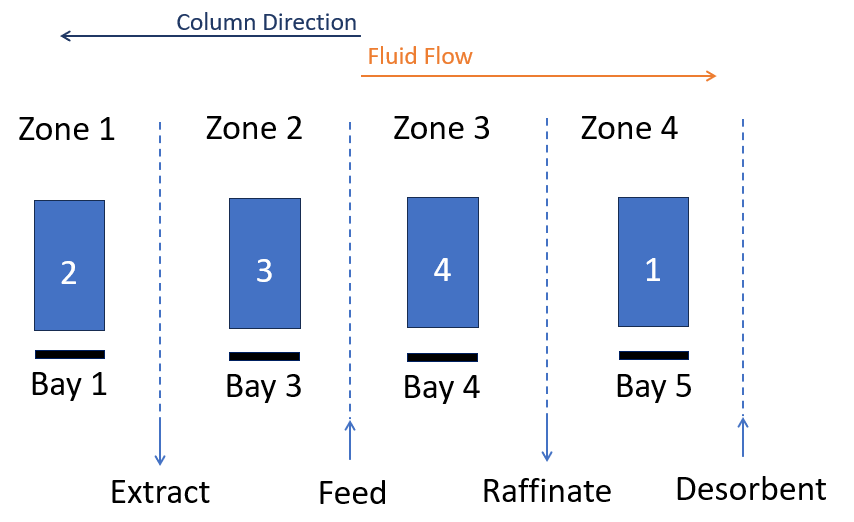


Notice the columns moved but the Bays didint! This is useful because now we can track the movement of any (and all) columns by just knowing the starting Bay. Fruther to this, in the university 

operation certain columns can be grouped. "Grouping" is simply a term that can be usde to remember how to allocate the effluent from one column-Bay to feed the next. In the conventional SMB operation

there is no grouping and each column is fed the effluent from the preceeding Bay: Bay 1 feeds Bay 2, Bay 2 feeds Bay 3 and so on. This is depicted in  below for the slightly larger 24 column configuration, 3:3:3:3.

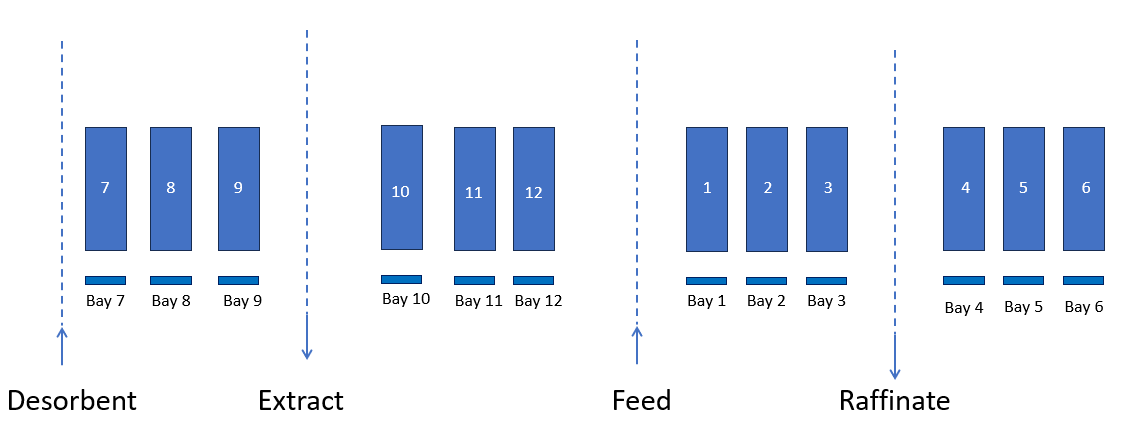

Now consider the case were we group columns 11 and 12. This means that they will share the effluent from column 10. Column 10s effluent is spilit and fed to both col 11 and col 12. Subsequently, the efflucent from col 11 and 12 is mixed and fed to col 1 (after adding the feed). This shown below.

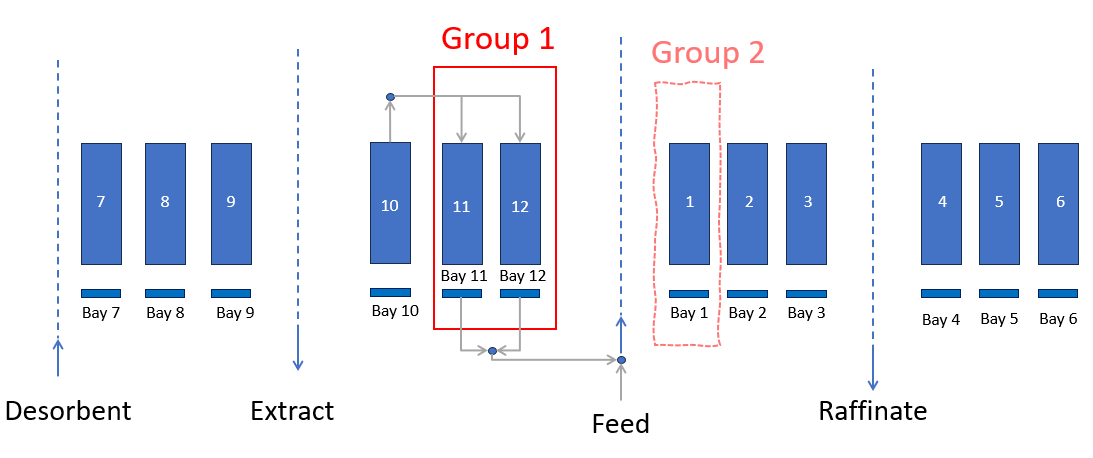

For short we can simply add the box without drawing the lines:

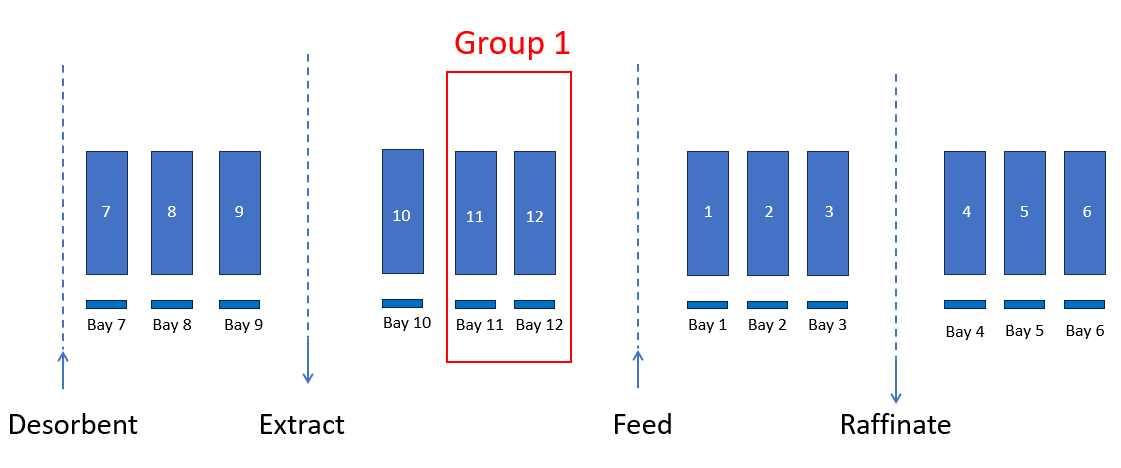

# Setting the Grouping Arrangement in the SMB model

Next, we see how the grouping arrangment can be translated to the model. 

The grouping style is incorperated in the "grouping_type" parameter. In this parameter, we list all the, n,  groups:

grouping_type = [grp_1, grp_2, grp_3, .........., grp_n] ---> where grp = group

grp_j = [[feed_bays], [receiving_bays]]

Where:
- grp_j is the jth group counted from the feed in the direction of the liquid flow.

- feed_bays: the bay(s) that feed the set of receiving bays in "receiving_bays"

- receiving_bays: the set of bays that receive material from the feed bay(s)

From the above example, the group formed by bays' 11 & 12 recieved the split effluent from bay 10, giving: grp1 = [[10], [11, 12]] "bay 10 feeds bays 11 and 12". We use the bays and not the 

columns themselves because the bays remain fixed throughout the operation; which ever column occupies the given bay folllows the "rule" in grp.


Notice also that we also need to incorperate the columns that are affected by the introduction of the group for instance, in the previous example, the column in bay 1 received the combined 

effuent from the group formed by bays' 11 & 12. In that case, we'd need to specify: grp2 = [[12, 11], [1]]. Therefore, to fully define the grouping from our 3:3:3:3 example write:


grp1 = [ [ 10 ] , [ 11, 12 ] ]

grp2 = [ [12 , 11 ], [ 1 ] ] 

grouping_type = [grp1, grp2] 




## Grouping Examples

#### 1. (12 col, 3:3:3:3) - Example configuration

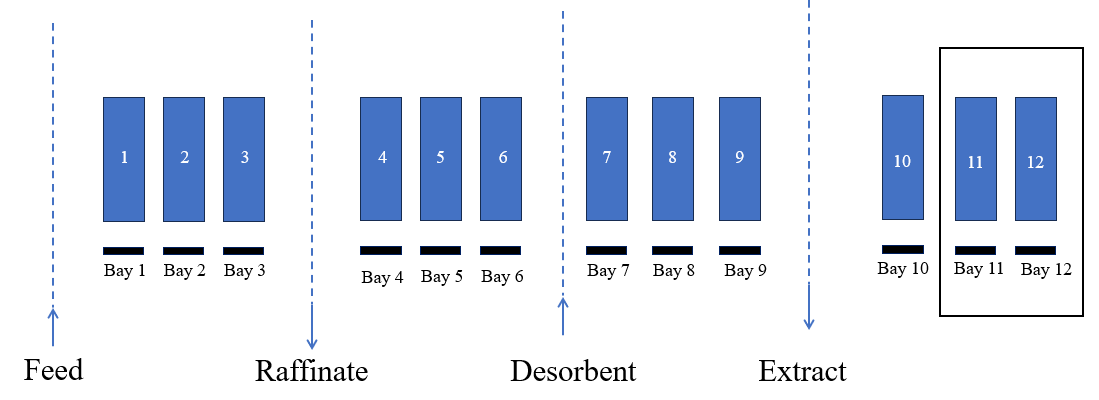



In [12]:
grp1 = [ [ 10 ] , [ 11, 12 ] ]

grp2 = [ [12 , 11 ], [ 1 ] ] 

grouping_type_example = [grp1, grp2] 

#### 2. (24 col, 3:9:3:9) Config for Glucose Fructose Commissioning 


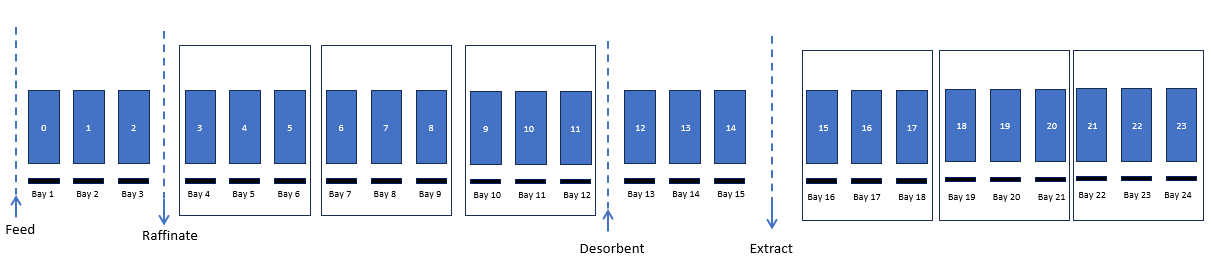

In [13]:
# 2. 24 col Config for Glucose Fructose Commissioning 
grp_1 = [[3], [4,5,6]] # ---> in group 1, there are 2 columns stationed at bay 3 and 4. Bay 3 and 4 recieve feed from bay 1"""
grp_2 = [[4,5,6], [7,8,9]] 

grp_3 = [[7,8,9], [10,11,12]] 
grp_4 = [[10,11,12], [13]]

grp_5 = [[15],[16, 17, 18]]
grp_6 = [[16, 17, 18],[19, 20, 21]]
grp_7 = [[19, 20, 21], [22, 23, 24]]
grp_8 = [[22, 23, 24], [1]]

# PACK:
grouping_type_GF_commissiong = [grp_1, grp_2, grp_3, grp_4, grp_5, grp_6, grp_7, grp_8]


#### 2. (24 col, 6:6:6:6) Config for Borate-HCl

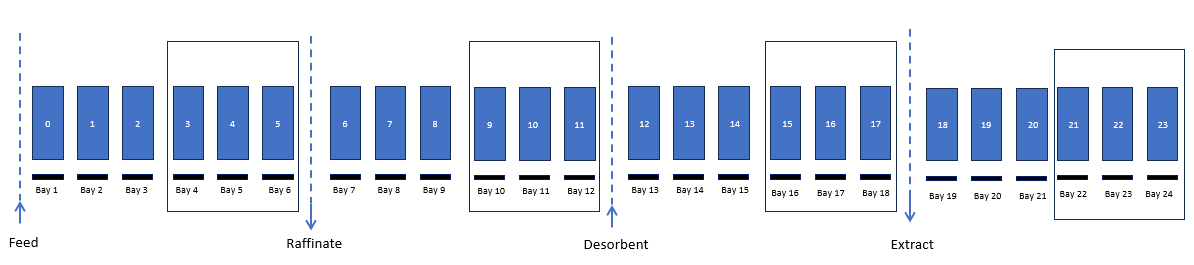

In [14]:
# 3.  24 col Config for Borate HCl
grp_1 = [[22, 23, 24], [1]] # ---> in subzone 1, there are 2 columns stationed at bay 3 and 4. Bay 3 and 4 recieve feed from bay 1"""

grp_2 = [[3], [4,5,6]] 
grp_3 = [[4,5,6], [7]] 

grp_4 = [[9], [10, 11, 12]] 
grp_5 = [[10,11,12], [13]]

grp_6 = [[15],[16, 17, 18]]
grp_7 = [[16, 17, 18],[19]]

grp_8 = [[21],[22, 23, 24]]

# # PACK:
grouping_type_BH_illovo = [grp_1, grp_2, grp_3, grp_4, grp_5, grp_6, grp_7, grp_8]


#### Set the Grouping

In [15]:

# Defult - No Subzoning (can apply to any number of columns)
default_grouping = []

grouping_type = default_grouping # = no_subzoning

#### Species Thermodynamic Parameters

All the thermodynamic parameters are stored in the species dictionary: species_dict. Please pay close attention to units.

Typically, you would have measured the feed concentrations for each sepcied prior th running the SMB - this information is stored in C_feed in (g/cm³)

Kinetic parameters such as H, kav and Da would have been determined from regression onto column test data.

In [16]:
species_dict = {

        "Glucose": {
            "color": "red",         # Plot color
            "C_feed": 0.0430,       # Feed concentration (g/cm³)

            "H": 0.27,              # Henry's constant
            "kav": [0.031],         # Mass Transfer coefficient parameters
            "Da": 6.41e-7           # Dispersion coefficient (cm²/s)


        },
        "Fructose": {
            "color": "green",
            "C_feed": 0.0430 * 0.75,
            
            "H": 0.53,
            "kav": [0.0218],
            "Da": 6.41e-7
        }
}


# No need to change below this line
# Extract species names
Names = list(species_dict.keys())
num_comp = len(Names)       # Number of components
iso_type = 'CUP'            # UNC or CUP

# Extract plot colors
color = [species_dict[name]["color"] for name in Names]

# Extract feed concentrations
parameter_sets = [{"C_feed": species_dict[name]["C_feed"]} for name in Names]

# Extract Henry's constants into a NumPy array
cusotom_isotherm_params_all = np.array([[species_dict[name]["H"]] for name in Names])

# Extract kav parameters
kav_params_all = [species_dict[name]["kav"] for name in Names]

# Extract axial dispersion coefficients
Da_all = np.array([species_dict[name]["Da"] for name in Names])




#### Operating Parameters

The parameter "n_num_cycles" defines the number of complete switching cycles the SMB system will execute during the simulation. 

Each cycle represents a full rotation of the inlet and outlet ports. For example, Setting n_num_cycles = 2 means the simulation will run through two full cycles. 

Alternatively you may want to specify the number of hours of operation rather than the nunmber of cycles; the parameter "t_simulation_end" specifies the total simulation time in hours. 

If set to "t_simulation_end = None", the simulation duration will be automatically determined based on the number of cycles. Conversly, if "n_num_cycles = None" the simulation duration 

will be determined based on the t_simulation_end. 

Note:
- As a heuristic, Cyclic Steady State (CSS) is typucally reached after 8-10 cycles.



In [17]:
n_num_cycles = 2  # Number of Cycles you want the SMB to run for 
t_simulation_end = None # HRS

#### Other Simulation Parameters

The SMB model uses finite differencing to solve transport equations in each column. 

The parameter nx_per_col sets the number of spatial nodes per column. 

Higher values improve resolution but significantly increase computation time. 

Based on prior testing, nx_per_col = 15 offers a good balance between accuracy and speed


In [18]:
nx_per_col = 15 # Number of spatial discretizations per column

### Assigning Optimization Variables


##### ⚙️ Optimization Parameter Overview

This section defines the configuration for optimizing SMB performance, targeting either purity, recovery, or a weighted combination.

- **Objective Direction**  
  `job_max_or_min = 'maximize'`  
  Specifies whether to maximize or minimize the objective function for this context set to 'maximize'.

- **Mass Transfer Coefficient Bounds**  
  `m_max = 6`, `m_min = 4`  
  Defines the search range for Flowrate ratios. `Bm` can be set if a fixed value is preferred.

- **Reference Time**  
  `t_reff = 20` (minutes)  
  Used to normalize switching time.

- **Flowrate Constraints**  
  `Q_max = 12`, `Q_min = 1` (L/h)  
  Sets bounds on allowable external flowrates during optimization. This is based on the mechanical limits of the pumps on the pilot plant - check the pump curves.

- **Sampling and Optimization Budgets**  
  `sampling_budget = 1`, `optimization_budget = 2`  
  Controls the number of initial samples and total optimization iterations.

- **Performance Constraints**  
  `constraint_threshold = [0.995, 0.995]`  
  Minimum required purity and recovery levels (e.g., 99.5%).

- **Objective Weighting**  
  `PF_weight = 10`  
  Emphasizes purity in the objective function. Higher values prioritize purity over recovery.

- **Variance Scaling**  
  `x_i = 0.01`  
  Scales the variance term in the objective function to penalize instability.

- **Optimization Bounds**  
  `bounds = [...]`  
  Specifies search intervals for decision variables:  
  - `m1`, `m2`, `m3`, `m4`: Mass transfer coefficients  
  - `t_index/t_reff`: Normalized switching time

---

Let me know if you'd like to include a brief on the optimizer type (e.g., Bayesian, grid search) or visualize the parameter space for workshop clarity.




In [19]:
# Do you want to maximize or minimize the objective function?
job_max_or_min = 'maximize' # 'maximize' or 'minimize'
m_max, m_min, = 6, 4 # Max and min mass transfer coefficients to consider
Bm = None
# - - - - - 
# Primary Varaibles
# - - - - -
t_reff = 20 # min # Reference time for normalization
# - - - - -
Q_max = 12 # L/h # Constraints on the external flowrates
Q_min = 1 # L/h

sampling_budget = 1 # 
optimization_budget = 20
constraint_threshold = [0.995, 0.995] # [Purity Constraint, Recovery Constraint] # 0.98, 0.99, 0.995
# - - - - -
PF_weight = 10 # Weighting factor for purity in the objective function | 1, 5, 10, 20
# - - - - -
x_i = 0.01 # power to which the variance is multiplied | 1, 2, 5, 10, 100
# - - - - -
# - - - - -


##### Guidance for Setting bounds and the Initial Guess

Decision variables were selected to be the 4 flowrate ratios and the indexing time:[m_1,m_2,m_3,m_4,t^* ]. From triangle theory, it was shown that the “prefect” separation region occurs close to the m_2=m_3 line. 
Therefore, better separation occurs when ∆m_3,2 is small, or, when m_2 and m_3 are similar. With this, both m_2 and m_3 were each set to be bounded slightly beyond H_fructose = 0.53 and beneath H_glucose = 0.27. 
Additionally,  m_1 and m_4 are set to be bounded well-beyond and beneath H_fructose = 0.53 and H_glucose = 0.27 respectively. Irrespective of the indexing time, any sensible operation conditions are likely to 
follow this pattern - for instance, the replicated operating point from Subramani et al (2003) follows: [m_1,m_2,m_3,m_4] = [0.51, 0.30, 0.41, 0.16] with t^*= 3.30 minutes




In [20]:
bounds = [
(5, 6),     # m1
(4, 5.5),   # m2
(4, 5.5),   # m3
(1, 3.5),   # m4

(0.1, 1)    # t_index/t_reff (normalized)
]

2.2 Initial Guess

2.2.1. First Define functions that convert the flowrate ratios to internal flowrates and vise versa

In [21]:
def mj_to_Qj(mj, t_index_min):
    '''
    Converts flowrate ratios to internal flowrates - flowrates within columns
    '''
    Qj = (mj*V_col*(1-e) + V_col*e)/(t_index_min*60) # cm^3/s
    return Qj

def Qj_to_mj(Qj, t_index_min):
    '''
    Converts flowrate ratios to internal flowrates - flowrates within columns
    '''
    mj = (Qj * t_index_min*60 - V_col*e)/(V_col*(1-e)) # cm^3/s
    return mj


2.2.2. Set the initial Guess

In [22]:
t_index_min = 10 # min (Placeholder, will be optimized)
triangle_guess = np.array([5.5, 4.20, 4.71, 3, t_index_min])

In [23]:
# Calcualte the internal flowrates

m1, m2, m3, m4 = triangle_guess[0],triangle_guess[1],triangle_guess[2],triangle_guess[3]
Q_I, Q_II, Q_III, Q_IV = mj_to_Qj(m1, t_index_min), mj_to_Qj(m2, t_index_min), mj_to_Qj(m3, t_index_min), mj_to_Qj(m4, t_index_min) # (L/h) Internal flowrates
Q_internal = np.array([Q_I, Q_II, Q_III, Q_IV])

# File Storage Parameters

In [24]:
# When saving the json:
Description = [f"Description: Optimizting the Glu-Fru system for the sythetic solution on PCR.Ca. {optimization_budget+1} iterations. {zone_config} configuration. We placed a upper flowrate constraint of {Q_min}<Q<{Q_max} L/h"]
save_name_inputs = f"Inputs_Glu_Fru_commision_opt_{optimization_budget+1}iter.json" 
save_name_outputs = f"Outputs_Glu_Fru_commision_opt_{optimization_budget+1}iter.json"


#### Pack all Input Parameters

In [25]:
# 1. Optimization input parameters
opt_inputs = [Description, save_name_inputs, save_name_outputs, job_max_or_min, t_reff, Q_max, Q_min, m_max, m_min, sampling_budget, optimization_budget, constraint_threshold, PF_weight, bounds, triangle_guess, x_i]
# 2. SMB input parameters
SMB_inputs = [iso_type, Names, color, num_comp, nx_per_col, e, Da_all, Bm, zone_config, L, d_col, d_in, t_index_min, n_num_cycles, Q_internal, parameter_sets, cusotom_isotherm_params_all, kav_params_all, grouping_type, t_simulation_end]

# Pack:
# -------------------------------
batch = [opt_inputs, SMB_inputs]

# Run the Optimization

MOBO Optimization

In [26]:
print(f'Running the Optimization now...')
results = constrained_MOBO_func(batch, SMB)

Running the Optimization now...


 OPTIMIZATION INPUTS: 

Column Volume: 1394.0817400304707 cm^3 | 1.3940817400304706 L
Column CSA: 19.634954084936208 cm^2
Column Length: 71 cm
Column Diameter: 5 cm
Optimization Budget: 20
Sampling Budget: 1
pF_weight: 10
exploration (xi): 0.01
thresholds: [0.995, 0.995]
[Q_max, Q_min] = [12.0, 1.0] L/h
bounds:
m1: (5, 6)
m2: (4, 5.5)
m3: (4, 5.5)
m4: (1, 3.5)
t_index: (2.0, 20) min
[m1, m2, m3, m4]: [5.5, 4.2, 4.71, 3.0], t_index: 10.0
Q_internal: [6.92393931 5.59491472 6.11630129 4.36812279] cm^s/s
Q_internal: [24.92618151 20.14169298 22.01868463 15.72524203] L/h
----------------------------------
Q_external: [0.52138657 1.7481785  2.55581652 1.32902459] cm^s/s
Q_external: [1.87699165 6.29344261 9.20093948 4.78448853] L/h [F, Raff, D, Ext]
QR:-1.7481785019982103
QR:-1.7481785019982103
[0.72046515 0.73992469], [0.27953485 0.26007531]
Pur: 0.5769045217269415, 0.3991792594518196
Rec: 0.5409125445654613, 0.1859138873691251




 Generated Initial Samples 

## Plot Optimization Results

starting to unpack
done loading
shape m1: (21,)


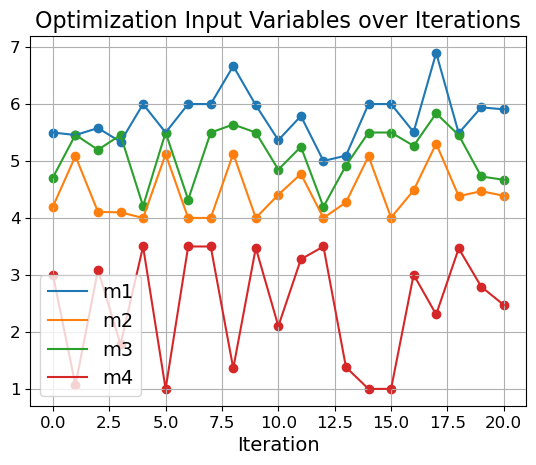

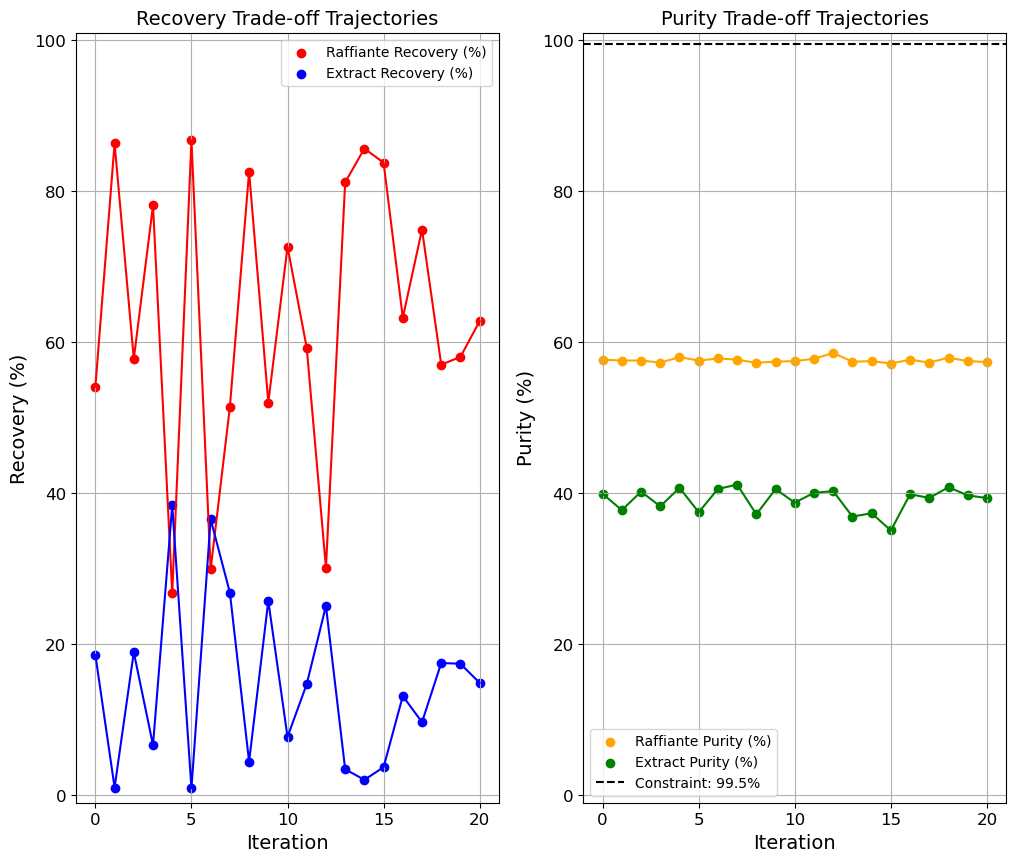

C:\Users\nawau\OneDrive\Desktop\smb_optimization_files\ploting_json_optimization_results.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()


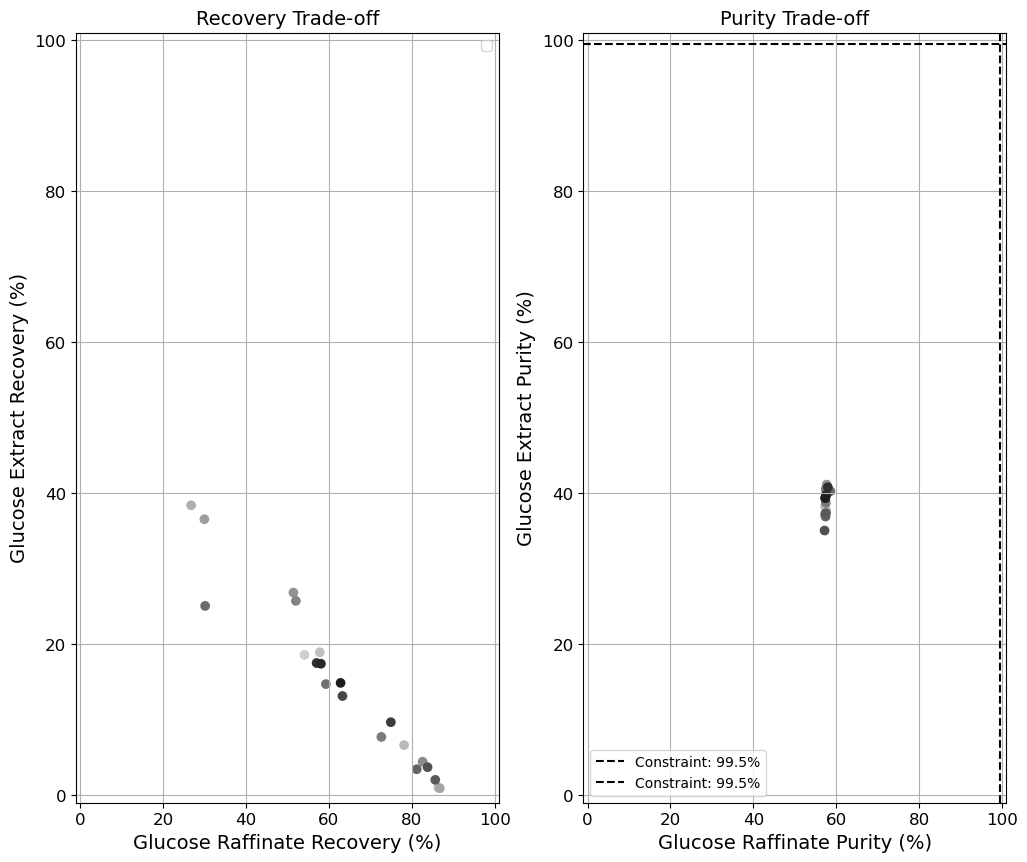


===== Pareto Front Summary =====
Glucose Pareto-optimal points: 6
Fructose Pareto-optimal points: 2
Dual-optimal points (both fronts): 0

Feasible points (Purity ≥ 99.5%): 0



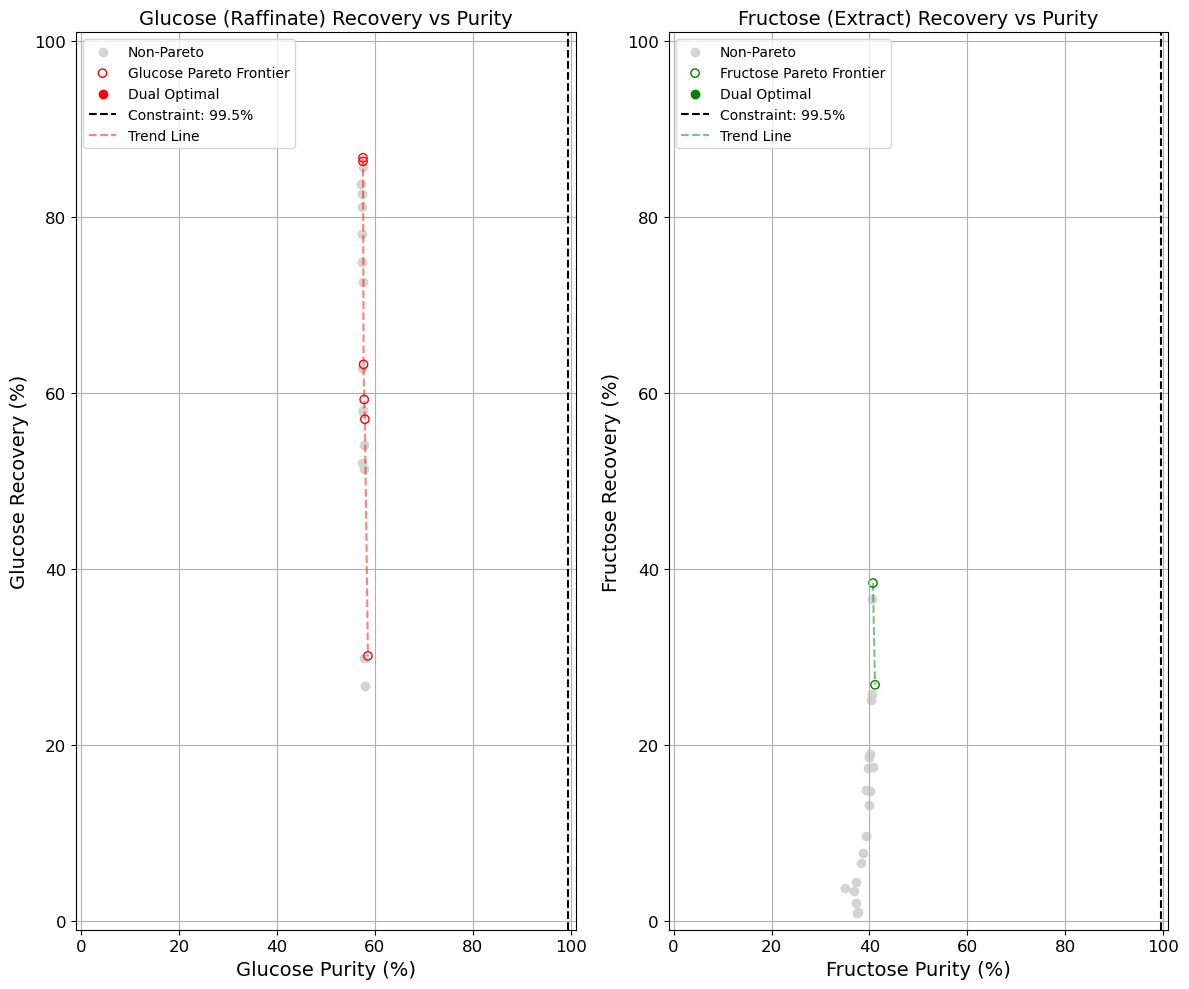

In [31]:
outputs_path = "Outputs_Glu_Fru_commision_opt_21iter_20251104_175024.json"
inputs_path = "Inputs_Glu_Fru_commision_opt_21iter_20251104_175024.json"

plot_raff_ext_pareto(inputs_path, outputs_path, purity_constraint=99.5, comp_1_name="Glucose", comp_2_name="Fructose")
